In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import datetime as dt
import pdb

import nilm_metric as nm
from data_store import LOCAL_DATA_DIR
from data_preprocessing import ActivationDetector

Populating the interactive namespace from numpy and matplotlib


In [2]:
predictions_store_pointnet = LOCAL_DATA_DIR + '/predictions/pointnet_large_separate_valid.h5'
predictions_store_fcn = LOCAL_DATA_DIR + '/predictions/fully_conv_separate_valid.h5'

In [3]:
readings = pd.read_hdf(predictions_store_fcn, '/home_73/kettle')

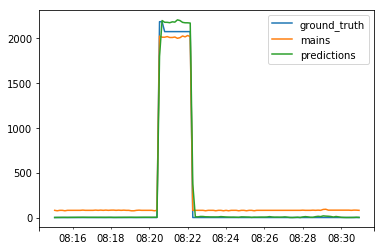

In [4]:
readings['2017-08-08 08:15':'2017-08-08 08:30'].plot()

In [5]:
readings = pd.read_hdf(predictions_store_pointnet, '/home_73/kettle')

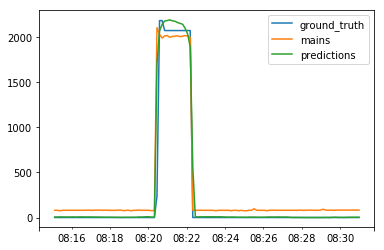

In [6]:
readings['2017-08-08 08:15':'2017-08-08 08:30'].plot()

In [7]:
nm.get_nde(readings.ground_truth, readings.predictions)

0.14948982604266803

In [8]:

test_homes = np.genfromtxt('test_homes.csv').astype(int)

models = {'fcn': predictions_store_fcn,
          's2p': predictions_store_pointnet}

nde = pd.DataFrame(index=pd.Series(list(models.keys()), name='model'),
                   columns={'homeid': test_homes}, dtype=float)
appliance = 'kettle'

for home in test_homes:
    for name, pred_store in models.items():
        with pd.HDFStore(pred_store) as s:
            results_name = '/home_{0}/{1}'.format(home, appliance)
            if results_name in s.keys():
                readings = s[results_name]
                nde.loc[name, home] = nm.get_mae(readings.ground_truth,
                                                 readings.predictions)

nde['mean'] = nde.mean(axis=1)
nde.round(3).style.highlight_min()

,homeid,73,227,249,264,mean
model,,,,,,
fcn,nan,1.208,11.035,23.632,5.569,10.361
s2p,nan,3.473,16.503,24.501,8.727,13.301


# Mean of metrics across all homes and appliances

In [9]:
metrics = {'NDE': nm.get_nde, 'MAE(watt)': nm.get_mae, 'SAE': nm.get_sae}
appliances = ['kettle','microwave','washingmachine','dishwasher', 'electricshower','electriccooker']

results = pd.DataFrame(index=pd.Series(list(models.keys()), name='model'),
                      columns=list(metrics.keys()))

for metric_name, metric in metrics.items():
    for model_name, pred_store in models.items():
        metric_values = []
        for appliance in appliances:
            appliance_metric_values = []
            for home in test_homes:
                results_name = '/home_{0}/{1}'.format(home, appliance)
                with pd.HDFStore(pred_store) as s:
                    if results_name in s.keys():
                        readings = s[results_name]
                        appliance_metric_values.append(
                            metric(readings.ground_truth, readings.predictions))
            metric_values.append(np.mean(appliance_metric_values))
        results.loc[model_name, metric_name] = np.mean(metric_values)


In [10]:
results.style.format({'NDE':'{:.3f}', 'MAE(watt)':'{:.1f}', 'SAE':'{:.3f}'})

,NDE,MAE(watt),SAE
model,,,
fcn,0.472,14.9,0.329
s2p,0.481,34.8,0.669
